In [ ]:
%pip install chumpy

In [5]:
import numpy as np
import scipy
import chumpy as ch       # pip install git+https://github.com/scottandrews/chumpy.git@fe51783e0364bf1e9b705541e7d77f894dd2b1ac
import pickle
import sys
import cv2 as cv

def write_int(file, val):
    file.write(int(val).to_bytes(4, byteorder=sys.byteorder))

def write_arr(file, arr):
    file.write(arr.tobytes())

class Mano:
    def __init__(self, path):
        self.path = path
        self._read()

    def print_data_format(self, data):
        """Useful for understanding stored data format in pkl file"""
        for key, value in data.items():
            print(f"{key}:\t{type(value)}", end=" ")
            if isinstance(value, np.ndarray):
                print(value.shape)
            elif isinstance(value, scipy.sparse.csc.csc_matrix):
                print(value.shape)
            elif isinstance(value, str):
                print(value)
            elif isinstance(value, ch.reordering.Select):
                print(value.shape)

        # output:
        # hands_components:   <class 'numpy.ndarray'> (45, 45) each row is a basis vector i.e. 45 basis vectors in 45 dimension
        # f:                  <class 'numpy.ndarray'> (1538, 3) faces
        # J_regressor:        <class 'scipy.sparse.csc.csc_matrix'> (16, 778)
        # kintree_table:      <class 'numpy.ndarray'> (2, 16) [:,i]=[parent[i],i]
        # J:                  <class 'numpy.ndarray'> (16, 3)
        # bs_style:           <class 'str'> lbs
        # hands_coeffs:       <class 'numpy.ndarray'> (1554, 45) what is this?
        # weights:            <class 'numpy.ndarray'> (778, 16)
        # posedirs:           <class 'numpy.ndarray'> (778, 3, 135) pose blends
        # hands_mean:         <class 'numpy.ndarray'> (45,)
        # v_template:         <class 'numpy.ndarray'> (778, 3)
        # shapedirs:          <class 'chumpy.reordering.Select'> (778, 3, 10) shape blends
        # bs_type:            <class 'str'> lrotmin

    def _read(self):
        """Reads MANO data from pkl file."""
        with open(self.path, "rb") as file:
            data = pickle.load(file, encoding="latin1")

        
        # parameters required (names as per paper)
        self.V_temp = data["v_template"]
        self.J_reg = data["J_regressor"]
        self.S = np.array(data["shapedirs"])
        self.P = data["posedirs"]
        self.W = data["weights"]

        # pose pca parameters
        self.pose_pca_basis = data["hands_components"]
        self.pose_pca_mean = data["hands_mean"]
        self.data_pose_pca_coeffs = data["hands_coeffs"]

        # supporting parameters
        self.triangles = data["f"]
        self.parent = data["kintree_table"][0].astype(np.int32)

        # dependent parameters
        self.n_joints = self.J_reg.shape[0]
        self.n_vertices = self.V_temp.shape[0]
        self.n_triangles = self.triangles.shape[0] 

        # n_comps = 7
        # hands_components = data["hands_components"]
        # hands_mean = data["hands_mean"]
        # hands_coeffs = data["hands_coeffs"]
        # selected_components = hands_components[:n_comps]
        # pose_coeffs = np.zeros(3+n_comps)   # 3: global orientation
        # full_hand_pose = pose_coeffs[3:].dot(selected_components)
        # print(hands_coeffs[1000])

In [10]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import json
import cv2
import tensorflow as tf
from tensorflow import keras
import os
import datetime
from mesh_sampling import generate_transform_matrices
from glob import glob
import time
import scipy
from psbody.mesh import Mesh

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
# Global Constants
EPSILON = 0.0001
AUGMENT = 1
PAD = 30
SEQ_LENGTH = 8              ##Spiral convolulational neighbourhood length
OUT_IMAGE_SIZE = (224, 224) ## Paper says 192x192 crops

CROP_OFFSET_RANGE = [-5, 5]
ROTATION_RANGE = [-180, 180]

## Hyperparameters
lamb_edge = 0.01
lamb_vert = 0.01
learning_rate = 1e-4
boundaries = [90, 120]
lr_values = [learning_rate, learning_rate*0.1, learning_rate*0.01]

storage_dir = "./drive/MyDrive/data/"
log_dir = storage_dir + "logs/"

imagenet_mean=np.array([0.485, 0.456, 0.406])
imagenet_std=np.array([0.229, 0.224, 0.225])

In [ ]:
tf.debugging.experimental.enable_dump_debug_info(storage_dir+"data/logs", tensor_debug_mode="FULL_HEALTH", circular_buffer_size=-1)

In [ ]:
tf.debugging.disable_check_numerics()

In [6]:
def bounding_box(points, augment=1):
    """
    Get the hand's bounding box based on annotation coordinates
    """
    x_coordinates, y_coordinates, z_coordinates = zip(*points)
    random_offsets = np.random.randint(*CROP_OFFSET_RANGE, (2, 3))
    return np.array([[min(x_coordinates), min(y_coordinates), min(z_coordinates)], [max(x_coordinates), max(y_coordinates), max(z_coordinates)]])+random_offsets*augment

In [7]:
def translation_mat(tx=0, ty=0, tz=0):
    """
    4x4 translational matrix
    """
    mat = np.eye(4)
    mat[0:3, 3] = np.array([tx, ty, tz]).T
    return mat

In [8]:
def scaling_mat(sx=1, sy=1, sz=1):
    """
    4x4 scaling matrix
    """
    return np.diag([sx, sy, sz, 1])

In [9]:
def shift_vertices(vertex_set, augment=1, pad=PAD):
    """
    Shift vertices based on the crop of hand from image
    """
    bbx = bounding_box(vertex_set).astype(int)
    mat = translation_mat(*(-1*(bbx[0,:]-pad)))
#     print(mat)
    adjusted_vertices = np.hstack([vertex_set.copy(), np.ones((len(vertex_set), 1))])
    adjusted_vertices = (adjusted_vertices @ mat.T)
    return adjusted_vertices, mat, bbx

In [10]:
def flip_hand(adjusted_vertices, mat, cropped_image, is_left):
    """
    Flip left hand to mirrored right hand coordinates
    """
    flip_mat = np.eye(4)
    if is_left:
        cropped_image = cropped_image[:, -1::-1, :]
        flip_mat = translation_mat(cropped_image.shape[1])
        flip_mat[0, 0] = -1
        adjusted_vertices = adjusted_vertices @ flip_mat.T
    return cropped_image, adjusted_vertices, flip_mat

In [11]:
def crop_image(image, width, height, bbx, pad=PAD):
    image = np.asarray(image.resize((width, height), 2))
    cropped_image = image[bbx[0][1]-pad:bbx[1][1]+pad, bbx[0][0]-pad:bbx[1][0]+pad, :]
    return cropped_image

In [12]:
def visualize_in_orig_image(image_path, width, height, annotations):
    """
    Visualize hand annotations and image on uncropped image
    """
    image = Image.open(image_path)
    image = image.resize((width, height), 2)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    vertices = np.array(annotations['vertices'])
    plt.plot(vertices[:, 0], vertices[:, 1], 'o', color='green', markersize=1)
    plt.show()

In [13]:
def visualize_in_processed_image(image_path, width, height, annotations):
    """
    Visualize hand annotations and image on cropped image
    """
    image = Image.open(image_path)
    adjusted_vertices, mat, bbx = shift_vertices(annotations['vertices'])
    cropped_image = crop_image(image, width, height, bbx)
    plt.imshow(cropped_image)
    vertices = np.array(adjusted_vertices)
    plt.plot(adjusted_vertices[:, 0], adjusted_vertices[:, 1], 'o', color='green', markersize=1)
    plt.show()

In [14]:
# def viz_3d(vertices, faces):
#     import open3d as o3d
    
#     mesh = o3d.geometry.TriangleMesh(o3d.utility.Vector3dVector(vertices), o3d.utility.Vector3iVector(faces))
#     o3d.visualization.draw_geometries([mesh])

In [15]:
def plot_and_show(image, vertex_set=None):
    """
    Visualize already cropped image and annotations
    """
    plt.imshow(image)
    if vertex_set is not None:
        plt.plot(vertex_set[:, 0], vertex_set[:, 1], 'o', color='green', markersize=1)
    plt.show()

In [16]:
def plot_vertices(vertex_set):
    """
    Plot just vertices as a 2D image
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(vertex_set[:, 0], vertex_set[:, 1], "go")
#     ax.set_xlim(-1, 1)
#     ax.set_ylim(1, -1)
    ax.set_aspect("equal")
    ax.invert_yaxis()
    plt.show()

In [17]:
def viz_3d(vert, faces):
    """
    Plot just vertices as a 3D image
    """
    mesh = Mesh(v=vert, f=faces)
    time.sleep(0.5)
    viewer = mesh.show()
    return 0

In [18]:
def map_img_to_path(img_dct, images):
    """
    Preprocessing function to create a image id to details mapping
    """
    for i in images:
        if i['id'] not in img_dct:
            img_dct[i['id']] = {}
        img_dct[i['id']]['path'] = i['name']
        img_dct[i['id']]['width'] = i['width']
        img_dct[i['id']]['height'] = i['height']

In [19]:
def map_img_to_ann(img_dct, annotations):
    """
    Preprocessing function to create a image id to list of annotations
    """
    for idx, ann in enumerate(annotations):
        if ann['image_id'] not in img_dct:
            img_dct[ann['image_id']] = {}
        if 'ann' not in img_dct[ann['image_id']]:
            img_dct[ann['image_id']]['ann'] = []
        img_dct[ann['image_id']]['ann'].append(idx)

In [7]:
def retrieve_sample(data, image_name):
    """
    Retrieve annotation for a particular image
    """
    annotation_list = []
    image = None
    for im in data['images']:
        if im['name'] == image_name:
            image = im
    
    for ann in data['annotations']:
        if ann['image_id'] == image['id']:
            annotation_list.append(ann)

    return annotation_list, image

In [21]:
def get_edge_mat(face_data, num_vert):
    """
    Get edge matrix of dimension Num_edges x Num_vertices
    Example :- [[1, 0, 0, -1, 0...], .. .. ]
    """
    edge_list = []
    for f in face_data:
        edge_list.append((f[0], f[1]) if f[0]<f[1] else (f[1], f[0]))
        edge_list.append((f[1], f[2]) if f[1]<f[2] else (f[2], f[1]))
        edge_list.append((f[2], f[0]) if f[2]<f[0] else (f[0], f[2]))
    edge_list = list(set(edge_list))
    print(edge_list)
    edge_mat = np.zeros((len(edge_list), num_vert))
    for idx, e in enumerate(edge_list):
        edge_mat[idx, e[0]]=1
        edge_mat[idx, e[1]]=-1
    return edge_mat

In [2]:
# Load full dataset
with open('../storage/YouTube-3D-Hands/youtube_train.json') as f:
    full_train_data = json.load(f)

In [23]:
with open(storage_dir+'sample.json') as f:
    sample_train_data = json.load(f)

In [8]:
train_data = full_train_data

In [9]:
sample_dataset = {"images":[], "annotations":[]}
image_lst = []
annotation_lst = []
for i in train_data['images']:
    if i['name'].split('/')[1]=="3tDnRKY0d3I":
        sample_dataset["images"].append(i)
        image_lst.append(i['id'])
for a in train_data['annotations']:
    if a['image_id'] in image_lst:
        annotation_lst.append(a)
sample_dataset['annotations']=annotation_lst

In [17]:

sample_dataset['images'][0]

{'id': 245889,
 'name': 'youtube/3tDnRKY0d3I/video/frames/173.png',
 'height': 720,
 'width': 1280}

In [10]:
with open('sample.json', 'w') as outfile:
    json.dump(sample_dataset, outfile)

In [26]:
print("Data keys:", [k for k in train_data.keys()])
print("Image keys:", [k for k in train_data['images'][0].keys()])
print("Annotations keys:", [k for k in train_data['annotations'][0].keys()])

print("The number of images:", len(train_data['images']))
print("The number of annotations:", len(train_data['annotations']))

Data keys: ['images', 'annotations']
Image keys: ['id', 'name', 'height', 'width']
Annotations keys: ['vertices', 'is_left', 'image_id', 'id']
The number of images: 1
The number of annotations: 1


In [27]:
train_img_to_ann = {}
map_img_to_path(train_img_to_ann, train_data['images'])
map_img_to_ann(train_img_to_ann, train_data['annotations'])

In [28]:
# Get the cropped image at this stage
annotation_list, image  = retrieve_sample(train_data, train_data['images'][0]['name'])

In [29]:
image

{'id': 245896,
 'name': 'youtube/3tDnRKY0d3I/video/frames/180.png',
 'height': 720,
 'width': 1280}

In [30]:
# annotation_list

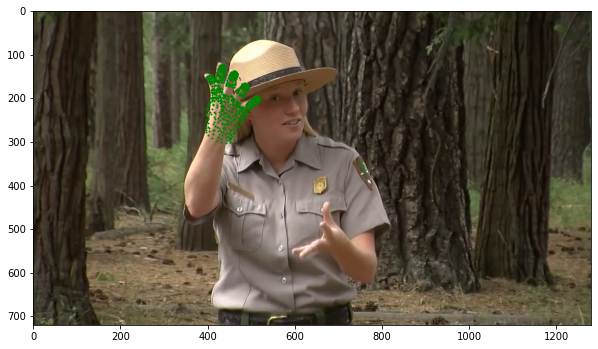

In [31]:
visualize_in_orig_image('../storage/data/'+image['name'], image['width'], image['height'], annotation_list[0])

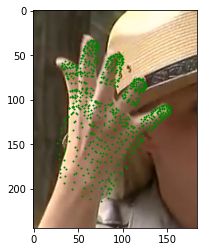

In [32]:
visualize_in_processed_image('../storage/data/'+image['name'], image['width'], image['height'], annotation_list[0])

In [33]:
# Process vertex set and image (Pipeline for a single image)
shifted_vertices, mat, bbx = shift_vertices(annotation_list[0]['vertices'])
orig_image = Image.open('../storage/data/'+image['name'])
cropped_image = crop_image(orig_image, image['width'], image['height'], bbx)

cropped_image, flipped_vertices, flip_mat = flip_hand(shifted_vertices, mat, cropped_image, 1)

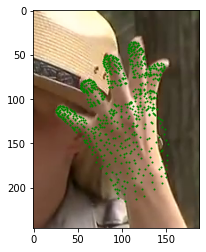

In [34]:
plot_and_show(cropped_image, flipped_vertices)

In [35]:
width = cropped_image.shape[1]
height = cropped_image.shape[0]
# print(width, height)

large_side = max(width, height)
scale = OUT_IMAGE_SIZE[0] / large_side

# image = image.thumbnail(OUT_IMAGE_SIZE, Image.ANTIALIAS)
scaled_image = Image.fromarray(cropped_image).resize((int(scale * width), int(scale * height)), 2)
# print(width*scale, height*scale)

scale_mat = scaling_mat(scale, scale)
width_padding = int(OUT_IMAGE_SIZE[0] - scale * width)
height_padding = int(OUT_IMAGE_SIZE[0] - scale * height)

pad_mat = translation_mat( width_padding/2, height_padding/2)
padded_image = Image.new("RGB", OUT_IMAGE_SIZE)
padded_image.paste(scaled_image, (width_padding//2, height_padding//2))

scaled_vertices = flipped_vertices @ scale_mat.T
padded_vertices = scaled_vertices @ pad_mat.T

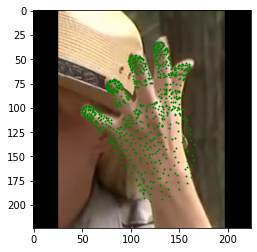

In [36]:
plot_and_show(padded_image, padded_vertices)

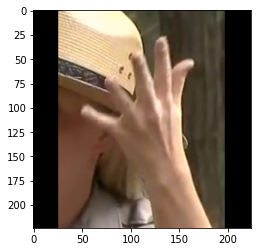

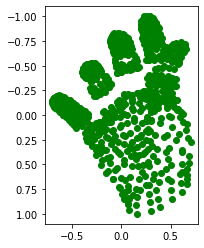

In [37]:
new_bbx = bounding_box(padded_vertices[:, 0:3], 0)
padded_image = np.array(padded_image)
normalized_image = padded_image / 255
# print(normalized_image.max())
plot_and_show(normalized_image)

vertex_scale = new_bbx[1, :] - new_bbx[0, :]
vertex_scale[:] = vertex_scale.max()/2
normalize_mat = (translation_mat(*((- new_bbx[0, :] - new_bbx[1, :])/2)).T @
                    scaling_mat(*(1/(vertex_scale+EPSILON))).T).T
normalized_vertices = padded_vertices @ normalize_mat.T

plot_vertices(normalized_vertices)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[  0.93310855  -0.4453773   57.37409962]
 [  0.4453773    0.93310855 -42.39041579]]


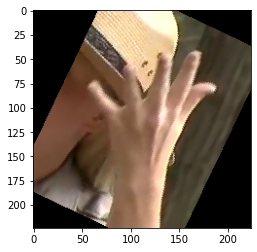

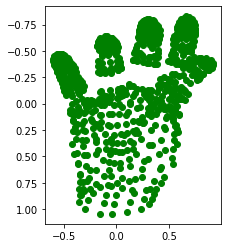

In [38]:
# Random rotation and scale
random_angle_in_degrees = np.random.rand() * (ROTATION_RANGE[1]-ROTATION_RANGE[0]) - ROTATION_RANGE[0]
random_scale = np.random.rand()*0.1 + 1.0
cv_mat_rot_scale = cv2.getRotationMatrix2D((OUT_IMAGE_SIZE[0]/2, OUT_IMAGE_SIZE[1]/2), random_angle_in_degrees, random_scale)
rotated_and_scaled_image = cv2.warpAffine(normalized_image, cv_mat_rot_scale, OUT_IMAGE_SIZE, borderValue=0, flags=cv2.INTER_NEAREST)
rotated_and_scaled_image *= random_scale

print(cv_mat_rot_scale)
mat_rot_scale = np.eye(4, dtype=np.float32)
mat_rot_scale[:2, :2] = cv_mat_rot_scale[:2, :2]
rotated_scaled_vertices = normalized_vertices @ mat_rot_scale.T
plot_and_show(rotated_and_scaled_image)
plot_vertices(rotated_scaled_vertices)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


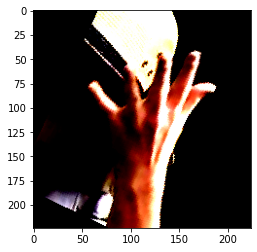

In [39]:
## Dataset Normalization (Images)
intensity_normalized_image = (rotated_and_scaled_image - imagenet_mean)/imagenet_std
plot_and_show(intensity_normalized_image)
## Normalize anns using dataset stats

In [40]:
def process_data_wrapper(image_path, image_width, image_height, hand_is_left, annotation_idx, augment):
    #Load these in process_ds for parallelisation
    annotations = train_data['annotations'][annotation_idx.numpy()]['vertices']
    image = Image.open(image_path.numpy())
    
    image_height = image_height.numpy()
    image_width = image_width.numpy()
    hand_is_left = hand_is_left.numpy()
    
    annotations_uvd, normalized_image, normalized_annotations, affine_mat = process_data(image, image_width, image_height, hand_is_left, annotations, augment)
    
    return annotations_uvd, normalized_image, normalized_annotations, affine_mat

In [41]:
def process_data(image, image_width, image_height, hand_is_left, annotation, augment):
    shifted_vertices, mat, bbx = shift_vertices(annotation, augment)
    cropped_image = crop_image(image, image_width, image_height, bbx)

    cropped_image, flipped_vertices, flip_mat = flip_hand(shifted_vertices, mat, cropped_image, hand_is_left)
    
    width = cropped_image.shape[1]
    height = cropped_image.shape[0]

    large_side = max(width, height)
    scale = OUT_IMAGE_SIZE[0] / large_side

    scaled_image = Image.fromarray(cropped_image).resize((int(scale * width), int(scale * height)), 2)

    scale_mat = scaling_mat(scale, scale)
    width_padding = int(OUT_IMAGE_SIZE[0] - scale * width)
    height_padding = int(OUT_IMAGE_SIZE[0] - scale * height)

    pad_mat = translation_mat( width_padding/2, height_padding/2)
    padded_image = Image.new("RGB", OUT_IMAGE_SIZE)
    padded_image.paste(scaled_image, (width_padding//2, height_padding//2))

    scaled_vertices = flipped_vertices @ scale_mat.T
    padded_vertices = scaled_vertices @ pad_mat.T
    
    new_bbx = bounding_box(padded_vertices[:, 0:3], 0)
    padded_image = np.array(padded_image)
    normalized_image = padded_image / 255.0
    
    vertex_scale = new_bbx[1, :] - new_bbx[0, :]
    vertex_scale[:] = vertex_scale.max()/2
    normalize_mat = (translation_mat(*((- new_bbx[0, :] - new_bbx[1, :])/2)).T @
                        scaling_mat(*(1/(vertex_scale+EPSILON))).T).T

    #### IMP How to dataset normalize annotations ???
    normalized_vertices = padded_vertices @ normalize_mat.T
    
    if augment:
        random_angle_in_degrees = np.random.rand() * (ROTATION_RANGE[1]-ROTATION_RANGE[0]) - ROTATION_RANGE[0]
    else:
        random_angle_in_degrees = 0

    cv_mat_rot = cv2.getRotationMatrix2D((OUT_IMAGE_SIZE[0]/2, OUT_IMAGE_SIZE[1]/2), random_angle_in_degrees, 1)
    rotated_image = cv2.warpAffine(normalized_image, cv_mat_rot, OUT_IMAGE_SIZE, borderValue=0, flags=cv2.INTER_NEAREST)
    
    intensity_normalized_image = (rotated_image - imagenet_mean) / imagenet_std
    
    
    mat_rot = np.eye(4, dtype=np.float32)
    if augment:
        mat_rot[:2, :2] = cv_mat_rot[:2, :2]
    rotated_vertices = normalized_vertices @ mat_rot.T
    
    affine_mat = mat_rot @ pad_mat @ scale_mat @ flip_mat @ mat
    return annotation, rotated_image, rotated_vertices[:, :3], affine_mat[:3, :3]

In [42]:
def get_raw_data_as_tf_dataset(storage_dir, images, annotations):
    image_dct = {}
    image_path = []
    image_width = []
    image_height = []
    hand_is_left = []
    annotation_idx = []
    map_img_to_path(image_dct, images)
    map_img_to_ann(image_dct, annotations)
    for idx, img in enumerate(image_dct.keys()):
        image_dct[img]['path'] = os.path.join(storage_dir, image_dct[img]['path'])
        for ann in image_dct[img]['ann']:
            image_path.append(image_dct[img]['path'])
            image_width.append(image_dct[img]['width'])
            image_height.append(image_dct[img]['height'])
            hand_is_left.append(annotations[ann]['is_left'])
            annotation_idx.append(ann)

        if idx > 2000:
            break
        
    
    ds_raw = tf.data.Dataset.from_tensor_slices((image_path, image_width, image_height, hand_is_left, annotation_idx))

    return ds_raw

In [43]:
def process_ds(image_path, image_width, image_height, hand_is_left, annotation_idx, augment):
    #Load image and annotations from text file later
    
    annotations_uvd, normalized_image, normalized_annotations, affine_mat = tf.py_function(
        func = process_data_wrapper,
        inp = [image_path, image_width, image_height, hand_is_left, annotation_idx, augment],
        Tout = [tf.float32, tf.float32, tf.float32, tf.float32]
    )
    
    annotations_uvd.set_shape([778, 3])
    normalized_image.set_shape([OUT_IMAGE_SIZE[0], OUT_IMAGE_SIZE[1], 3])
    normalized_annotations.set_shape([778, 3])
    affine_mat.set_shape([3, 3])
    
#     return (
#         {"normalized_image" : normalized_image, "affine_mat" : affine_mat},
#         {"normalized_annotations" : normalized_annotations, "annotations_uvd" : annotations_uvd}
#     )
    return normalized_image, normalized_annotations

In [44]:
def process_tf_dataset(ds_raw, augment):
    ds_processed = ds_raw.map(
                        lambda image_path, image_width, image_height, hand_is_left, annotation_id : process_ds(
                                image_path, image_width, image_height, hand_is_left, annotation_id, augment))
    
    return ds_processed

In [45]:
def get_processed_dataset_as_tf_dataset(storage_dir, images, annotations):
    ds_raw = get_raw_data_as_tf_dataset(storage_dir, images, annotations)
    
    n_data = ds_raw.cardinality().numpy()
    train_frac = 1
    n_data_train = int(n_data * train_frac)
    ds_train = ds_raw.take(n_data_train)
    ds_val = ds_raw.skip(n_data_train)
    
    ds_train = process_tf_dataset(ds_train, True)
    ds_train = ds_train.apply(tf.data.experimental.ignore_errors())
    ds_val = process_tf_dataset(ds_val, False)

    return ds_train, ds_val
    

In [46]:
ds_train, ds_val = get_processed_dataset_as_tf_dataset('../storage/data', train_data['images'], train_data['annotations'])

In [47]:
ds_train = ds_train.shuffle(1000).batch(32)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)
ds_val = ds_val.batch(32)
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)

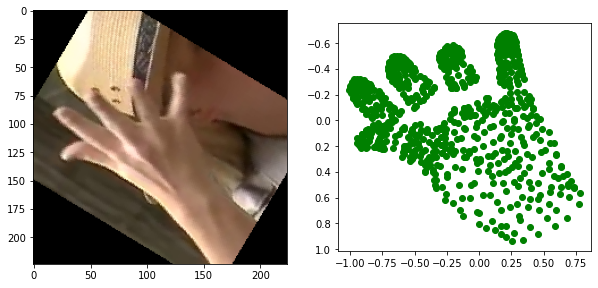

In [48]:
#Check output
fig = plt.figure(figsize=(10,10))
for ds in ds_train:
    plt.subplot(121)
    plt.imshow(ds[0][0].numpy())
    ax = fig.add_subplot(122)
    vertex_set = ds[1][0].numpy()
    ax.plot(vertex_set[:, 0], vertex_set[:, 1], "go")
    ax.set_aspect("equal")
    ax.invert_yaxis()
    break

In [49]:
##Mesh Sampling

In [7]:
mano = Mano('../storage/MANO_RIGHT.pkl')
# v_temp_bbx = bounding_box(mano.V_temp, 0)
# MANO_SCALE = tf.convert_to_tensor((v_temp_bbx[1,:]-v_temp_bbx[0,:])/2, dtype=tf.float32)
# MANO_SCALE

In [8]:
mesh = Mesh(v=mano.V_temp, f=mano.triangles)

In [11]:
M,A,D,U = generate_transform_matrices(mesh, [2, 2, 2, 2])

/Users/debabratamandal/sem8/RnD/code/RnD/dataset/mesh_sampling.py:67: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coeffs_v[3 * i:3 * i + 3] = np.linalg.lstsq(A, nearest_v)[0]
/Users/debabratamandal/sem8/RnD/code/RnD/dataset/mesh_sampling.py:71: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  tmp_coeffs = np.linalg.lstsq(A, target.v[i])[0]


In [12]:
print("set of meshes", M)
print("Adjacency matrix", A)
print("Downsampling transforms", D)
print("Upsampling transforms", U)

set of meshes [<psbody.mesh.mesh.Mesh object at 0x146cd8518>, <psbody.mesh.mesh.Mesh object at 0x146625fd0>, <psbody.mesh.mesh.Mesh object at 0x146cd8390>, <psbody.mesh.mesh.Mesh object at 0x103bb3710>, <psbody.mesh.mesh.Mesh object at 0x103bb3208>]
Adjacency matrix [<778x778 sparse matrix of type '<class 'numpy.float64'>'
	with 4630 stored elements in Compressed Sparse Column format>, <389x389 sparse matrix of type '<class 'numpy.float64'>'
	with 2298 stored elements in Compressed Sparse Column format>, <195x195 sparse matrix of type '<class 'numpy.float64'>'
	with 1138 stored elements in Compressed Sparse Column format>, <98x98 sparse matrix of type '<class 'numpy.float64'>'
	with 558 stored elements in Compressed Sparse Column format>, <49x49 sparse matrix of type '<class 'numpy.float64'>'
	with 266 stored elements in Compressed Sparse Column format>]
Downsampling transforms [<389x778 sparse matrix of type '<class 'numpy.float64'>'
	with 389 stored elements in Compressed Sparse Colu

In [128]:
import scipy.sparse
for i in range(4):
    u = U[-(i+1)]
    scipy.sparse.save_npz('upsampling_matrix'+str(i+1)+'.npz', u)

u1 = scipy.sparse.load_npz('upsampling_matrix1.npz')
u1

<98x49 sparse matrix of type '<class 'numpy.float64'>'
	with 294 stored elements in Compressed Sparse Column format>

In [13]:
import scipy.sparse
for i in range(4):
    d = D[i]
    scipy.sparse.save_npz('downsampling_matrix'+str(i+1)+'.npz', d)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


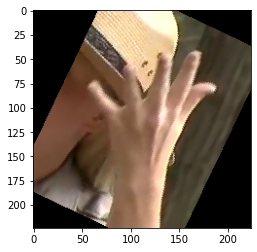

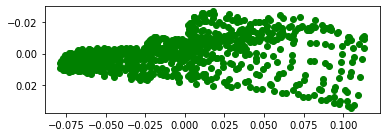

In [60]:
plot_and_show(rotated_and_scaled_image)
# plot_vertices(M[0].v)
# viz_3d(rotated_scaled_vertices[:,:3], mano.triangles)
down_sampled = (M[1].v.T @ U[0].T).T
plot_vertices(down_sampled)
# show(rotated_scaled_vertices[:,:3], mano.triangles)

In [61]:
## Code from SpiralConve paper
def _next_ring(mesh, last_ring, other):
    res = []

    def is_new_vertex(idx):
        return (idx not in last_ring and idx not in other and idx not in res)

    for vh1 in last_ring:
        vh1 = om.VertexHandle(vh1)
        after_last_ring = False
        for vh2 in mesh.vv(vh1):
            if after_last_ring:
                if is_new_vertex(vh2.idx()):
                    res.append(vh2.idx())
            if vh2.idx() in last_ring:
                after_last_ring = True
        for vh2 in mesh.vv(vh1):
            if vh2.idx() in last_ring:
                break
            if is_new_vertex(vh2.idx()):
                res.append(vh2.idx())
    return res


def extract_spirals(mesh, seq_length, dilation=1):
    # output: spirals.size() = [N, seq_length]
    spirals = []
    for vh0 in mesh.vertices():
        reference_one_ring = []
        for vh1 in mesh.vv(vh0):
            reference_one_ring.append(vh1.idx())
        spiral = [vh0.idx()]
        one_ring = list(reference_one_ring)
        last_ring = one_ring
        next_ring = _next_ring(mesh, last_ring, spiral)
        spiral.extend(last_ring)
        while len(spiral) + len(next_ring) < seq_length * dilation:
            if len(next_ring) == 0:
                break
            last_ring = next_ring
            next_ring = _next_ring(mesh, last_ring, spiral)
            spiral.extend(last_ring)
        if len(next_ring) > 0:
            spiral.extend(next_ring)
        else:
            kdt = KDTree(mesh.points(), metric='euclidean')
            spiral = kdt.query(np.expand_dims(mesh.points()[spiral[0]],
                                              axis=0),
                               k=seq_length * dilation,
                               return_distance=False).tolist()
            spiral = [item for subspiral in spiral for item in subspiral]
        spirals.append(spiral[:seq_length * dilation][::dilation])
    return spirals


def preprocess_spiral(face, seq_length, vertices=None, dilation=1):
    assert face.shape[1] == 3
    if vertices is not None:
        mesh = om.TriMesh(np.array(vertices), np.array(face))
    else:
        n_vertices = face.max() + 1
        mesh = om.TriMesh(np.ones([n_vertices, 3]), np.array(face))
    spirals = extract_spirals(mesh, seq_length=seq_length, dilation=dilation)
    return spirals

In [62]:
class SpiralConv(tf.keras.layers.Layer):
    
    def __init__(self, in_channels, out_channels, indices, dim=1):
        super(SpiralConv, self).__init__()
        self.dim = dim
        self.indices = indices
        self.nodes = tf.shape(indices)[0]
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.inp_dense = self.in_channels*tf.shape(indices)[1]
        self.layer = tf.keras.layers.Dense(out_channels)
        
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        x = tf.reshape(tf.gather(inputs, tf.reshape(self.indices, [-1]), axis=1), [batch_size, self.nodes, self.inp_dense])
        return x
    
    def model(self):
        inputs = tf.keras.Input(shape=(self.nodes, self.in_channels))
        x = self.call(inputs)
        outputs = self.layer(x)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        return model

In [63]:
in_channels = 2
out_channels = 3
batch_size = 1
indices = [[0, 1, 2], [1, 2, 0], [2, 1, 0]]
nodes = tf.shape(indices)[0]
inp_dense = in_channels*tf.shape(indices)[1]
inp = [[[0, 0], [1, 1], [-1, -1]]]
out = tf.reshape(tf.gather(inp, tf.reshape(indices, [-1]), axis=1), [batch_size, nodes, inp_dense])
tf.print(out)

[[[0 0 1 1 -1 -1]
  [1 1 -1 -1 0 0]
  [-1 -1 1 1 0 0]]]


In [64]:
class Upsampling(tf.keras.layers.Layer):
    ## Sparse Mult code from coma
    def __init__(self, upsampling_matrix):
        super(Upsampling, self).__init__()
        self.mat = upsampling_matrix
        type(self.mat)
        self.mat = self.mat.tocoo()
        indices = np.column_stack((self.mat.row, self.mat.col))
        self.mat = tf.sparse.SparseTensor(indices, self.mat.data, self.mat.shape)
        self.mat = tf.sparse.reorder(self.mat)
        self.Mp = self.mat.shape[0]
    
    def call(self, inputs):
        N = tf.shape(inputs)[0]
        M = tf.shape(inputs)[1]
        Fin = tf.shape(inputs)[2]
        N, M, Fin = int(N), int(M), int(Fin)

        x = tf.transpose(inputs, perm=[1, 2, 0])  # M x Fin x N
        x = tf.reshape(x, [M, -1])  # M x Fin*N
        ##Speed up using sparse matrix multiplication
        x = tf.sparse.sparse_dense_matmul(self.mat, x) # Mp x Fin*N
        x = tf.reshape(x, [self.Mp, Fin, -1])  # Mp x Fin x N
        x = tf.transpose(x, perm=[2,0,1]) # N x Mp x Fin
        return x

In [65]:
upml1 = Upsampling(scipy.sparse.csc_matrix.astype(U[0], dtype=np.float32))
upml2 = Upsampling(scipy.sparse.csc_matrix.astype(U[1], dtype=np.float32))

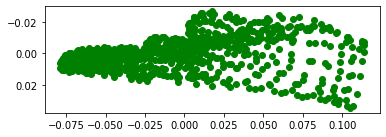

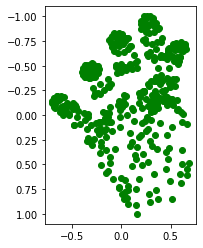

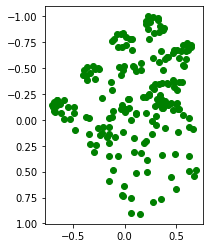

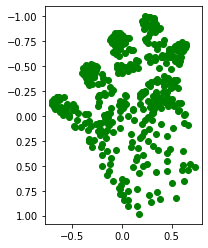

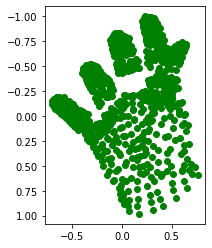

In [66]:
plot_vertices(mano.V_temp)
down_sampled = D[0] @ normalized_vertices[:,:3]
plot_vertices(down_sampled)
down_sampled = D[1] @ down_sampled
plot_vertices(down_sampled)

up_sampled = upml2.call(tf.convert_to_tensor([down_sampled], dtype=tf.float32))
plot_vertices(up_sampled[0])
up_sampled = upml1.call(tf.convert_to_tensor(up_sampled, dtype=tf.float32))
plot_vertices(up_sampled[0])

In [102]:
sparse_edge_mat = tf.convert_to_tensor(get_edge_mat(mano.triangles, len(mano.V_temp)), dtype=tf.float32)

[(566, 567), (716, 731), (193, 229), (358, 375), (587, 590), (491, 504), (74, 288), (645, 648), (336, 337), (174, 176), (525, 557), (468, 469), (692, 693), (472, 475), (238, 280), (682, 684), (421, 430), (42, 88), (498, 509), (499, 505), (560, 571), (144, 274), (116, 118), (389, 395), (603, 620), (506, 508), (754, 755), (425, 447), (544, 547), (619, 620), (121, 214), (33, 34), (529, 530), (415, 422), (36, 41), (735, 745), (61, 63), (657, 661), (550, 566), (719, 720), (12, 129), (325, 326), (440, 453), (155, 273), (410, 452), (400, 408), (201, 627), (397, 453), (128, 172), (160, 162), (550, 553), (635, 658), (135, 173), (501, 503), (104, 287), (243, 257), (595, 596), (636, 658), (70, 72), (723, 731), (44, 120), (190, 235), (390, 404), (688, 694), (697, 712), (76, 246), (446, 448), (765, 766), (468, 482), (97, 773), (354, 355), (722, 723), (432, 435), (35, 110), (325, 328), (753, 754), (229, 231), (638, 669), (44, 119), (559, 560), (70, 777), (533, 538), (532, 534), (644, 645), (424, 427

In [103]:
def get_sparse_edge_mat(edge_mat):
    """
    edge_mat: Num_edges_in_face*778 
    """
    edge_mat = scipy.sparse.csr_matrix(edge_mat)
    edge_mat = edge_mat.tocoo()
    indices = np.column_stack((edge_mat.row, edge_mat.col))
    edge_mat = tf.SparseTensor(indices, edge_mat.data, edge_mat.shape)
    edge_mat = tf.sparse.reorder(edge_mat)
    return edge_mat

In [104]:
tensor_edge_mat = get_sparse_edge_mat(sparse_edge_mat)

In [105]:
faces = [[1, 2, 3], [3, 4, 1], [4, 3, 8], [8, 5, 4], [5, 8, 7], [7, 6, 5], [6, 7, 2], [2, 1, 6], [1, 4, 5], [5, 6, 1], [8, 3, 2], [2, 7, 8]]
faces = list(np.array(faces)-1)
edge_mat = get_edge_mat(faces, 8)
print(edge_mat, edge_mat.shape)

[(0, 1), (1, 2), (2, 7), (4, 7), (6, 7), (4, 6), (5, 6), (4, 5), (1, 5), (2, 3), (1, 6), (0, 5), (0, 4), (3, 7), (0, 3), (3, 4), (0, 2), (1, 7)]
[[ 1. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0. -1.]
 [ 0.  0.  0.  0.  1.  0.  0. -1.]
 [ 0.  0.  0.  0.  0.  0.  1. -1.]
 [ 0.  0.  0.  0.  1.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  1. -1.  0.]
 [ 0.  0.  0.  0.  1. -1.  0.  0.]
 [ 0.  1.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  1. -1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0. -1.  0.]
 [ 1.  0.  0.  0.  0. -1.  0.  0.]
 [ 1.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0. -1.]
 [ 1.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -1.  0.  0.  0.]
 [ 1.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0. -1.]] (18, 8)


In [106]:
tfspm = tf.convert_to_tensor(edge_mat, dtype=tf.float64)
tfspm = get_sparse_edge_mat(edge_mat)
tf.print(tfspm)
# tensor_edge_mat = tfspm

'SparseTensor(indices=[[0 0]
 [0 1]
 [1 1]
 ...
 [16 2]
 [17 1]
 [17 7]], values=[1 -1 1 ... -1 1 -1], shape=[18 8])'


In [108]:
vertices = [[0, 1, 0], [0, 0, 0], [1, 0, 0], [1, 1, 0], [1, 1, -1], [0, 1, -1], [0, 0, -1], [1, 0, -1]]
y_true = [vertices]
y_true = tf.convert_to_tensor(y_true, dtype=tf.float64)

y_pred = [np.array(vertices)-[0, 1, 0]]
y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float64)

In [109]:
def loss_function(y_true, y_pred):
    num_verts = tf.shape(y_true)[1]
    num_edges = tf.shape(tensor_edge_mat)[0]
    y_true = tf.transpose(y_true, perm=[1, 2, 0]) # 778 x 3 x N
    y_true = tf.reshape(y_true, [num_verts, -1])
    y_pred = tf.transpose(y_pred, perm=[1, 2, 0]) # 778 x 3 x N
    y_pred = tf.reshape(y_pred, [num_verts, -1])
    edge_true = tf.sparse.sparse_dense_matmul(tensor_edge_mat, y_true) # num_edges x 3N
    edge_pred = tf.sparse.sparse_dense_matmul(tensor_edge_mat, y_pred) # num_edges x 3N
    edge_pred = tf.reshape(edge_pred, [num_edges, 3, -1])
    edge_true = tf.reshape(edge_true, [num_edges, 3, -1])
    y_pred = tf.reshape(y_pred, [num_verts, 3, -1]) # 778 x 3 x N
    y_pred = tf.transpose(y_pred, perm=[2, 0, 1]) # N x 778 x 3
    y_true = tf.reshape(y_true, [num_verts, 3, -1])
    y_true = tf.transpose(y_true, perm=[2, 0, 1]) # N x 778 x 3

#     tf.print(tf.shape(y_true), tf.shape(tf.reduce_sum(tf.norm(y_true - y_pred, ord=1, axis=1), axis=0)), tf.shape(tf.reduce_sum(tf.abs(tf.norm(edge_true, ord='euclidean', axis=1)**2 - tf.norm(edge_pred, ord='euclidean', axis=1)**2), axis=0)), output_stream=sys.stdout)
#     tf.print(tf.norm(edge_true, ord='euclidean', axis=1) - tf.norm(edge_pred, ord='euclidean', axis=1) , output_stream=sys.stdout)
#     tf.print(tf.reduce_mean(tf.norm(y_true - y_pred, ord=1, axis=1), axis=-1) , output_stream=sys.stdout)
#     tf.print(tf.reduce_mean(tf.reduce_mean(tf.abs(tf.norm(edge_true, ord=2, axis=1) - tf.norm(edge_pred, ord=2, axis=1)), axis=-1), axis=-1))
#     tf.print(tf.reduce_max(tf.abs(tf.norm(edge_true, ord=2, axis=1) - tf.norm(edge_pred, ord=2, axis=1))), output_stream=sys.stdout)
#     tf.autograph.trace()
#     tf.autograph.trace()

    return lamb_vert * tf.reduce_mean(tf.reduce_sum(tf.norm(y_true - y_pred, ord=1, axis=2), axis=1)) + lamb_edge * tf.reduce_mean(tf.reduce_sum(tf.abs(tf.norm(edge_true, ord='euclidean', axis=1)**2 - tf.norm(edge_pred, ord='euclidean', axis=1)**2), axis=0))

In [ ]:
tf.print(loss_function(y_true, y_pred))

In [111]:
class Error_Metric(tf.keras.metrics.Metric):
    def __init__(self, ann_scale, **kwargs):
        super(Error_Metric, self).__init__(**kwargs)
        self.vertex_distance_error = self.add_weight(name="vertex_dist_error", initializer='zeros')
        self.mean_error = self.add_weight(name="mean_vertex_dist_error", initializer='zeros')
        self.steps = self.add_weight(name="steps", initializer='zeros')
        self.scale = ann_scale

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.vertex_distance_error = tf.reduce_mean(tf.reduce_sum(tf.norm(tf.math.multiply(y_true - y_pred, 1/self.scale), ord=1, axis=2), axis=1)) 
        self.mean_error.assign_add(self.vertex_distance_error)
        self.steps.assign_add(1)

    def result(self):
        return self.vertex_distance_error

    def reset_states(self):
        self.mean_error.assign(0.0)
        self.steps.assign(0.0)

In [15]:
M[-2].v.shape

(98, 3)

In [81]:
indices1 = tf.convert_to_tensor(preprocess_spiral(M[-2].f, SEQ_LENGTH), dtype=tf.int32)
indices2 = tf.convert_to_tensor(preprocess_spiral(M[-3].f, SEQ_LENGTH), dtype=tf.int32)
indices3 = tf.convert_to_tensor(preprocess_spiral(M[-4].f, SEQ_LENGTH), dtype=tf.int32)
indices4 = tf.convert_to_tensor(preprocess_spiral(M[-5].f, SEQ_LENGTH), dtype=tf.int32)

In [ ]:
for i in range(4):
    indices = preprocess_spiral(M[-(i+2)].f, SEQ_LENGTH)
    with open('indices'+str(i+1)+'.npy', 'wb') as f:
        np.save(f, indices)

with open('indices'+str(1)+'.npy', 'rb') as f:
    indices_1 = np.load(f)

In [82]:
resnet50 = tf.keras.applications.ResNet50(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000)

up1 = Upsampling(scipy.sparse.csc_matrix.astype(U[-1], dtype=np.float32))
sconv1 = SpiralConv(48, 32, indices1).model()
up2 = Upsampling(scipy.sparse.csc_matrix.astype(U[-2], dtype=np.float32))
sconv2 = SpiralConv(32, 32, indices2).model()
up3 = Upsampling(scipy.sparse.csc_matrix.astype(U[-3], dtype=np.float32))
sconv3 = SpiralConv(32, 16, indices3).model()
up4 = Upsampling(scipy.sparse.csc_matrix.astype(U[-4], dtype=np.float32))
sconv4 = SpiralConv(16, 3, indices4).model()

In [83]:
inputs = tf.keras.Input(shape=(*OUT_IMAGE_SIZE, 3), name="normalized_image")

In [84]:
x = resnet50(inputs)

In [85]:
x = tf.keras.layers.Dense(64, activation=tf.keras.activations.relu , name="FC1")(x)

In [86]:
x = tf.keras.layers.Dense(49*48, activation=tf.keras.activations.relu, name="FC2")(x)

In [87]:
x = tf.keras.layers.Reshape((49, 48), name="reshape_to_mesh")(x)

In [88]:
x = up1(x)

In [89]:
x = sconv1(x)

In [90]:
x = up2(x)

In [91]:
x = sconv2(x)

In [92]:
x = up3(x)

In [93]:
x = sconv3(x)

In [94]:
x = up4(x)

In [95]:
x = sconv4(x)

In [96]:
outputs = x

In [97]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [98]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalized_image (InputLayer [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 1000)              25636712  
_________________________________________________________________
FC1 (Dense)                  (None, 64)                64064     
_________________________________________________________________
FC2 (Dense)                  (None, 2352)              152880    
_________________________________________________________________
reshape_to_mesh (Reshape)    (None, 49, 48)            0         
_________________________________________________________________
upsampling_2 (Upsampling)    (None, 98, None)          0         
_________________________________________________________________
model (Functional)           (None, 98, 32)            1232

In [112]:
## Implement scheduler
learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, lr_values)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=loss_function,
    metrics=[Error_Metric(MANO_SCALE)]
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [113]:
model.fit(ds_train, batch_size=1, epochs=10000, validation_data=ds_val,steps_per_epoch=1, 
          callbacks=[tensorboard_callback])

Epoch 1/10000
1/1 [==============================] - 7s 7s/step - loss: 8.0779 - error__metric_2: 15812.3809
Epoch 2/10000
1/1 [==============================] - 1s 847ms/step - loss: 8.1948 - error__metric_2: 15852.3613
Epoch 3/10000
1/1 [==============================] - 1s 566ms/step - loss: 8.2448 - error__metric_2: 15107.4912
Epoch 4/10000
1/1 [==============================] - 1s 649ms/step - loss: 8.1481 - error__metric_2: 13821.5605
Epoch 5/10000
1/1 [==============================] - 1s 578ms/step - loss: 8.0376 - error__metric_2: 15748.8311
Epoch 6/10000
1/1 [==============================] - 1s 565ms/step - loss: 8.0584 - error__metric_2: 15614.8291
Epoch 7/10000
1/1 [==============================] - 1s 697ms/step - loss: 8.0039 - error__metric_2: 13588.5342
Epoch 8/10000
1/1 [==============================] - 1s 593ms/step - loss: 7.9947 - error__metric_2: 13523.4912
Epoch 9/10000
1/1 [==============================] - 1s 552ms/step - loss: 8.2758 - error__metric_2: 14999.

KeyboardInterrupt: 

In [88]:
pred = model.predict(np.array([rotated_and_scaled_image]), batch_size=1)

In [89]:
viz_3d(pred[0], mano.triangles)

0

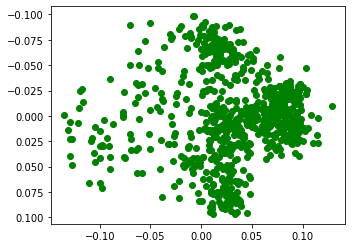

In [402]:
plot_vertices(pred[0])